# Error Estimation

## Load Environment

First, load necessary modules to be load in the following steps.

In [1]:
import numpy as np

## Load Hills

We could load hills from `HILLS` produced by Plumed, to do more analysis. 
Here, we just use the examples provided by V. Spiwok, 
which is trajectories of Alanine Dipeptide in water with 1, 2 or 3 Ramachandran angles, respectively.

In [2]:
from catflow.analyzer.metad.hills import Hills

In [3]:
#load hills
h2 = Hills(name="../../tests/analyzer/metad/data/hills/acealanme", periodic=[True,True], cv_per=[[-np.pi, np.pi], [-np.pi, np.pi]])

## Sum Hills using `Fes`

We could just use `metadynminer.fes` to sum the hills to get the Free Energy Surface (FES).

For example, here we just use the fast approach to draw the FES of `acealanme` (with 2 CVs).

In [4]:
from catflow.analyzer.metad.fes import FreeEnergySurface

# do sum_hills
fes = FreeEnergySurface.from_hills(h2, resolution=256)

(<Figure size 960x672 with 2 Axes>,
 <Axes: xlabel='CV1 - phi', ylabel='CV2 - psi'>)

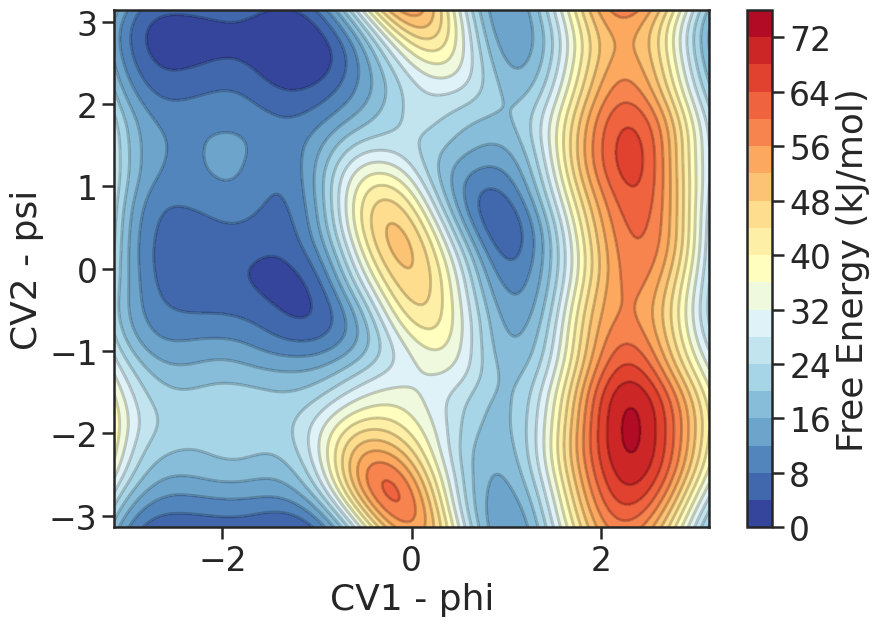

In [5]:
fes.make_fes_original(resolution=256, n_workers=4)
# plot the FES
fes.plot(cmap="RdYlBu_r", levels=20, dpi=96, style='ticks', context='talk')

(<Figure size 960x672 with 2 Axes>,
 <Axes: xlabel='CV1 - phi', ylabel='CV2 - psi'>)

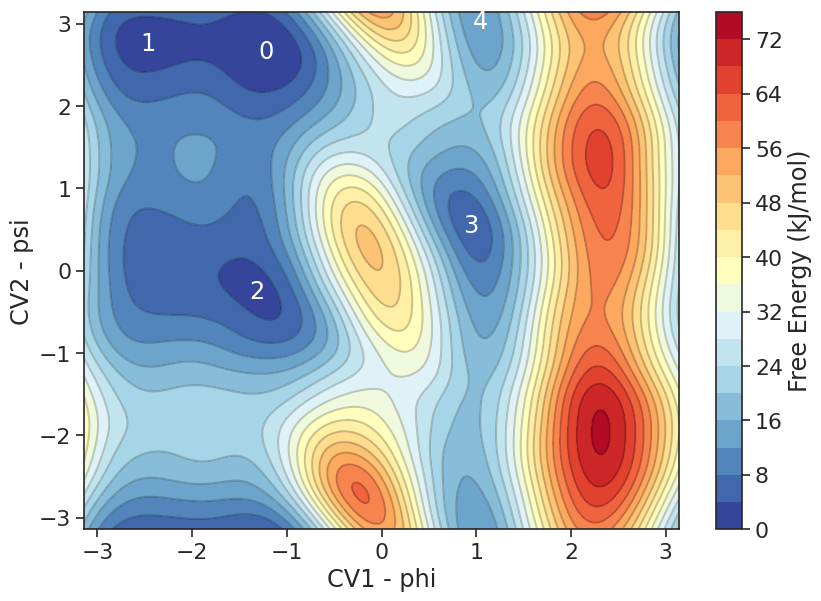

In [6]:
fes.find_minima()

# plot the minimas
fes.plot_minima(mark_color="white", png_name=None, style='ticks', context='notebook')

In [7]:
fes.minima

,Minimum,free energy,CV1bin,CV2bin,CV1 - phi,CV2 - psi
0,0,0.000000,78.0,236.0,-1.214913,2.662991
1,1,1.635963,27.0,240.0,-2.466641,2.761165
2,2,2.670061,74.0,117.0,-1.313088,-0.257709
3,3,5.255746,166.0,150.0,0.944932,0.552233
4,4,12.537359,170.0,251.0,1.043107,3.031146


## Error estimation

In [8]:
# do sum_hills
fes.save_fes_with_correction(resolution=256, temp=300.0)

100%|██████████| 30000/30000 [00:27<00:00, 1100.17it/s]


In [9]:
data = fes.load_fes_with_correction("fes_profile.hdf5", slice_string="::10")
data = np.array(data)

In [10]:
data.shape

(3000, 256, 256)

In [11]:
from catflow.utils.statistics import block_average

mean, var = block_average(data, 300, axis=0)

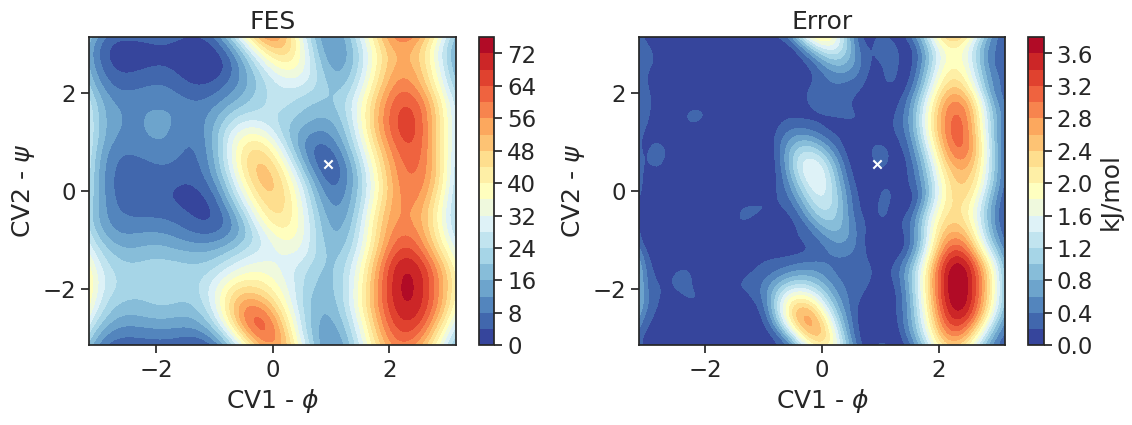

In [12]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(13, 4))
ax = axs[0]
pos = ax.contourf(fes.fes.T, levels=20, cmap="RdYlBu_r", extent=[-np.pi, np.pi, -np.pi, np.pi])
ax.scatter(0.944932, 0.552233, marker="x", color="white")
ax.set_title("FES")
ax.set_xlabel(r"CV1 - $\phi$")
ax.set_ylabel(r"CV2 - $\psi$")
fig.colorbar(pos, ax=ax)

ax = axs[1]
pos = ax.contourf(var.T, levels=20, cmap="RdYlBu_r", extent=[-np.pi, np.pi, -np.pi, np.pi]) # type: ignore
ax.scatter(0.944932, 0.552233, marker="x", color="white")
ax.set_title("Error")
ax.set_xlabel(r"CV1 - $\phi$")
ax.set_ylabel(r"CV2 - $\psi$")
colorbar = fig.colorbar(pos, ax=ax)
colorbar.set_label("kJ/mol")
plt.show()

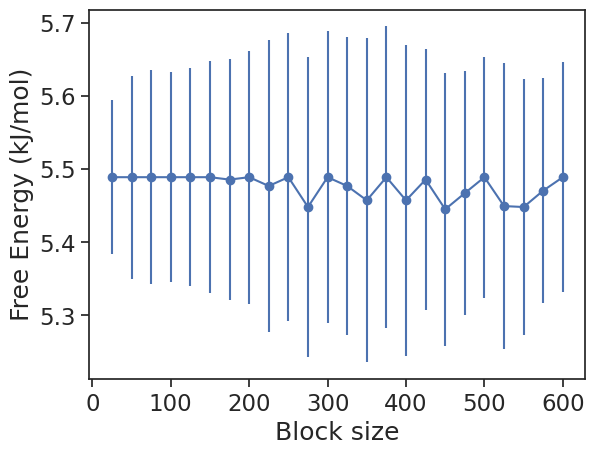

In [13]:
fig, ax = plt.subplots()
all_mean, all_var = [], []
for i in range(25, 601, 25):
    _mean, _var = block_average(data[:, 166, 150], i)
    all_mean.append(_mean[0]) # type: ignore
    all_var.append(_var[0]) # type: ignore
ax.errorbar(np.arange(25, 601, 25), all_mean, all_var, fmt="o-")
ax.set_xlabel("Block size")
ax.set_ylabel("Free Energy (kJ/mol)")
plt.show()